In [1]:
! nvidia-smi

Fri Jun 16 18:21:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

!pip install torchsummary
!pip install tqdm
from tqdm import tqdm
from torchsummary import summary
import sys
import os
%matplotlib inline
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

from Model_3 import *
from utils import *

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
train = datasets.MNIST('../data/MNIST', train=True, download=True, transform=train_transforms())
# The dataset named "MNIST" is being called from within the torchvision available datasets
# MNIST is a dataset containing handwritten digits
# The training part of the dataset is downloaded to ../data location
# This is also the Extract (E) part of the ETL process where we are going to extract the dataset from raw data
test = datasets.MNIST('../data/MNIST', train=False, download=True, transform=test_transforms())
# The test part of the dataset is downloaded to ../data location

100%|██████████| 9912422/9912422 [00:00<00:00, 285228152.85it/s]

Extracting ../data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 12321807.94it/s]


Extracting ../data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 120574137.81it/s]


Extracting ../data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6682051.48it/s]


Extracting ../data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw



In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

device = torch.device("cuda" if cuda else "cpu")

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64, num_workers=2, pin_memory=True)
# Batch Size is a tunable parameter that tells us how many images can be sent in parallel to the model.
# This depends on the available memory and can be increased/decreased accordingly. This is tuned after the model is ran and based on available memory

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
# trainloader is sort of "for" loop for us which will allow to look at or load a lot of images (~batch_size) at same time
# torch.utils.data.DataLoader wraps a dataset and provides access to the underlying data

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)
# test till help to check accuracy of our model

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [5]:
#return_image_stats(train)
# Since the train data is already Normalized, we will not get the actual mean and std values

torch.Size([128, 1, 28, 28])
torch.Size([128])


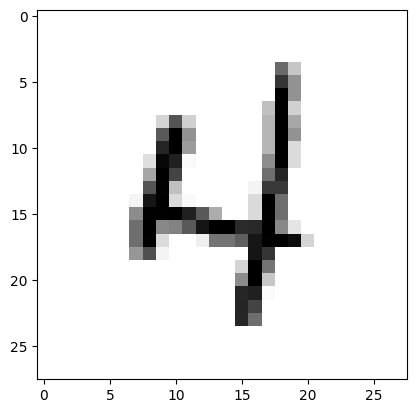

In [6]:
return_single_image(train_loader)

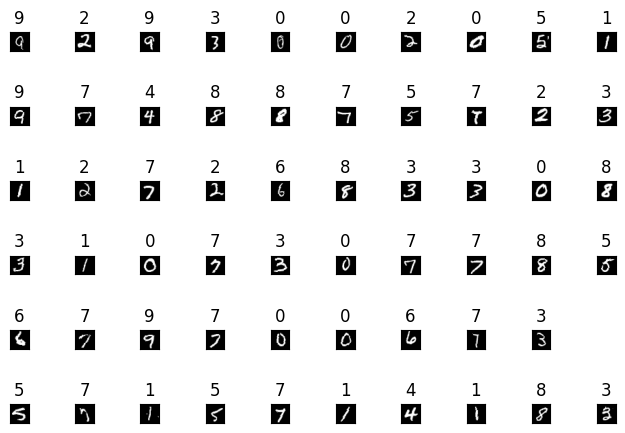

In [7]:
return_dataset_images(train_loader,60)

In [8]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [9]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
            Conv2d-4           [-1, 16, 24, 24]           1,152
       BatchNorm2d-5           [-1, 16, 24, 24]              32
              ReLU-6           [-1, 16, 24, 24]               0
           Dropout-7           [-1, 16, 24, 24]               0
            Conv2d-8            [-1, 8, 24, 24]             128
       BatchNorm2d-9            [-1, 8, 24, 24]              16
             ReLU-10            [-1, 8, 24, 24]               0
        MaxPool2d-11            [-1, 8, 12, 12]               0
           Conv2d-12           [-1, 16, 10, 10]           1,152
      BatchNorm2d-13           [-1, 16, 10, 10]              32
             ReLU-14           [-1, 16,

In [10]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

EPOCHS = 15
for epoch in range(1, EPOCHS+1):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 1


Loss=0.0715060830116272 Batch_id=468 Accuracy=89.95: 100%|██████████| 469/469 [00:21<00:00, 21.58it/s]



Test set: Average loss: 0.0843, Accuracy: 9736/10000 (97.36%)

EPOCH: 2


Loss=0.013289039023220539 Batch_id=468 Accuracy=97.61: 100%|██████████| 469/469 [00:26<00:00, 17.50it/s]



Test set: Average loss: 0.0536, Accuracy: 9832/10000 (98.32%)

EPOCH: 3


Loss=0.03327583149075508 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:22<00:00, 21.09it/s]



Test set: Average loss: 0.0412, Accuracy: 9872/10000 (98.72%)

EPOCH: 4


Loss=0.0599651075899601 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:22<00:00, 21.29it/s]



Test set: Average loss: 0.0353, Accuracy: 9896/10000 (98.96%)

EPOCH: 5


Loss=0.003911714535206556 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:20<00:00, 22.76it/s]



Test set: Average loss: 0.0356, Accuracy: 9890/10000 (98.90%)

EPOCH: 6


Loss=0.027918754145503044 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:20<00:00, 22.74it/s]



Test set: Average loss: 0.0457, Accuracy: 9840/10000 (98.40%)

EPOCH: 7


Loss=0.05308546498417854 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:23<00:00, 20.29it/s]



Test set: Average loss: 0.0293, Accuracy: 9909/10000 (99.09%)

EPOCH: 8


Loss=0.04042769595980644 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:21<00:00, 21.44it/s]



Test set: Average loss: 0.0282, Accuracy: 9907/10000 (99.07%)

EPOCH: 9


Loss=0.0033099085558205843 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:21<00:00, 21.44it/s]



Test set: Average loss: 0.0277, Accuracy: 9914/10000 (99.14%)

EPOCH: 10


Loss=0.019233593717217445 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:21<00:00, 21.45it/s]



Test set: Average loss: 0.0251, Accuracy: 9922/10000 (99.22%)

EPOCH: 11


Loss=0.020258476957678795 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:20<00:00, 22.42it/s]



Test set: Average loss: 0.0330, Accuracy: 9895/10000 (98.95%)

EPOCH: 12


Loss=0.02545231021940708 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:20<00:00, 22.73it/s]



Test set: Average loss: 0.0233, Accuracy: 9933/10000 (99.33%)

EPOCH: 13


Loss=0.013429153710603714 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:21<00:00, 21.70it/s]



Test set: Average loss: 0.0264, Accuracy: 9910/10000 (99.10%)

EPOCH: 14


Loss=0.031704988330602646 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:21<00:00, 21.36it/s]



Test set: Average loss: 0.0216, Accuracy: 9938/10000 (99.38%)

EPOCH: 15


Loss=0.0077429586090147495 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:22<00:00, 21.29it/s]



Test set: Average loss: 0.0222, Accuracy: 9933/10000 (99.33%)



In [11]:
train_losses

[tensor(2.3141, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3184, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3044, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3017, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2954, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2664, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2502, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2444, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2150, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2127, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.1705, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.1529, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.1478, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.0931, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.1047, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.0534, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(

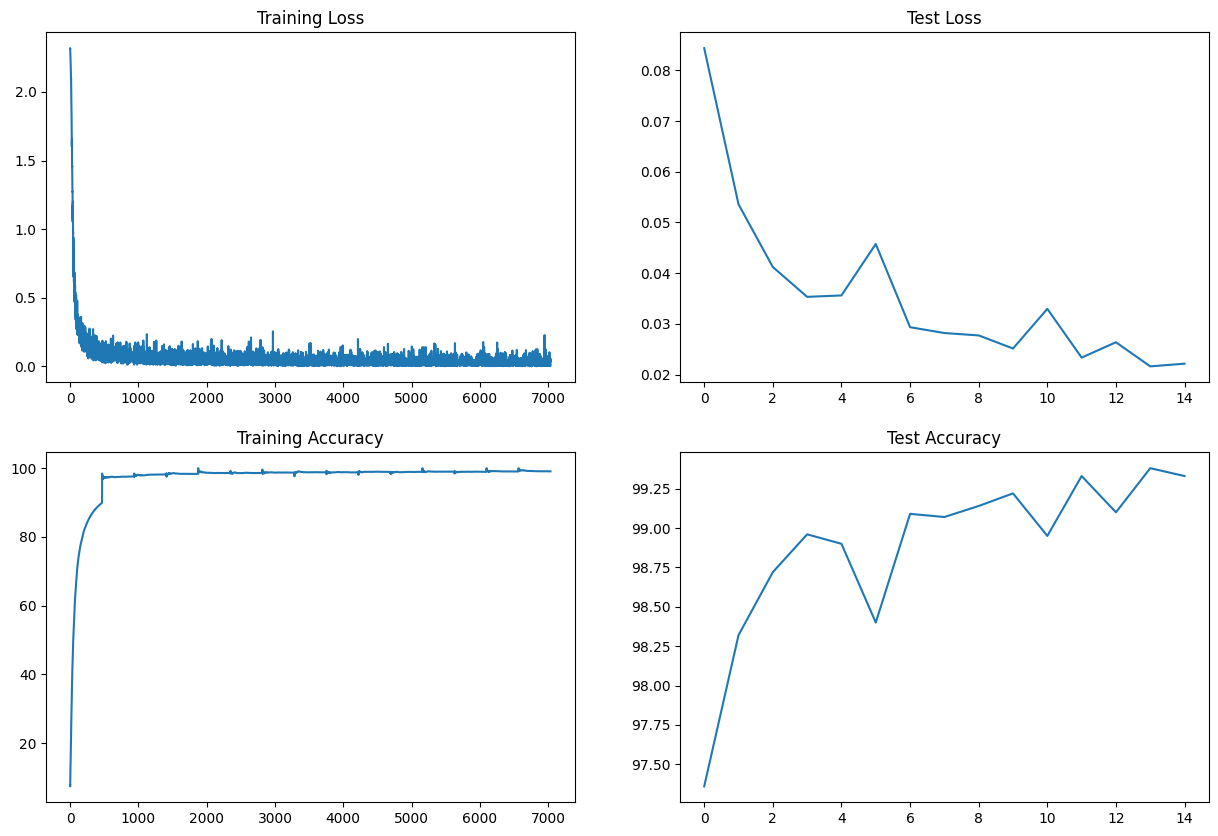

In [12]:
draw_graphs(train_losses, train_acc, test_losses, test_acc)